<img style="float: right;" src="https://2b838p24nks2163of0383y6z-wpengine.netdna-ssl.com/wp-content/uploads/2020/03/wordmark.png" width="10%"/>

# Train a Model

In this notebook, which can be run in your favorite Python notebook environment such as on your local machine, SageMaker, or Databricks, we will be training an XGBoost classifier to predict whether a transaction is fraudulent or not, using the training dataframe we constructed from stored Tecton features on our users layered in with the transactional information we added from our `fraud_transactions_pq` table.

We use pure Python here, so no need to run this in a Spark interface.

We'll assume you've already downloaded the training dataframe you generated in step 1 to a suitable location on your local machine, but you can just as easily load it from S3 using the `s3fs` library.

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from scikitplot.metrics import plot_precision_recall, plot_confusion_matrix, plot_roc
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

import mlflow
import pyarrow.parquet as pq

In [10]:
# Silence deprecation warnings from numpy and informational messages from mlflow
import warnings
import logging

warnings.filterwarnings("ignore", category=DeprecationWarning)
logger = logging.getLogger("mlflow")
logger.setLevel(logging.ERROR)

We'll load the training dataframe we created from Tecton above

In [11]:
df = pq.read_table('./data/fraud_dataset.parquet/').to_pandas()

We'll log our model to mlflow (bundled with Databricks) to make it easier to deploy our model to production, but you can use any model registry you'd like.

In [17]:
# Track this experiment and save model in the Databricks-managed mlflow instance
import os
os.environ['MLFLOW_TRACKING_URI']='databricks'
mlflow.start_run(experiment_id='1299164929996601')

<ActiveRun: >

In [18]:
mlflow.autolog()

In [19]:
# We're going to drop the user_id and timestamp fields from our training dataframe since those aren't relevant to our model training
X = df.drop(['isfraud', 'user_id', 'timestamp'], axis=1)
y = df.isfraud

In [20]:
# Split our training dataframe into train and test dataframes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [22]:
pipe = Pipeline([
  ('imputer', SimpleImputer(fill_value=0)),
  ('scaler', StandardScaler()),
  ('clf', XGBClassifier(random_state=42, use_label_encoder=False))
])

In [23]:
# Here you can run your pipeline through a hyperparameter optimizer like hyperopt or GridSearchCV
pipe.fit(X_train, y_train)

[15:06:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614844528294/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('imputer', SimpleImputer(fill_value=0)),
                ('scaler', StandardScaler()),
                ('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1, random_state=42,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               use_label_encoder=False, validate_parameters=1,
                    

## Scoring

We'll score our model to see how well it predicts against the test set: data it hasn't seen but for which we still have the right answer. No surprises here: we do very well in correctly predicting ok transactions but not fraudulent ones. This might be due to a few reasons: ok transactions may look more similar to each other than fraudulent transactions and there are comparatively fewer fraudulent transactions in the training dataset (aka a *class imbalance* problem).

In [24]:
# y_test_hat are the true/false predictions for whether a transaction is fraudulent. y_test_hat_proba is the numerical probability
# which is used in some of the metrics below. (You can also use the predict_proba results to create your own true/false threshold)
y_test_hat = pipe.predict(X_test.to_numpy())
y_test_hat_proba = pipe.predict_proba(X_test.to_numpy())

In [25]:
print(classification_report(y_test, y_test_hat))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     59467
           1       0.82      0.18      0.30       533

    accuracy                           0.99     60000
   macro avg       0.91      0.59      0.65     60000
weighted avg       0.99      0.99      0.99     60000



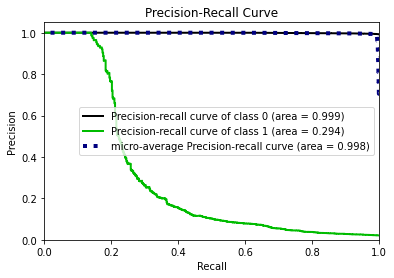

In [26]:
plot_precision_recall(y_test, y_test_hat_proba)
plt.savefig('./output/precision_recall.png')
mlflow.log_artifact('./output/precision_recall.png')

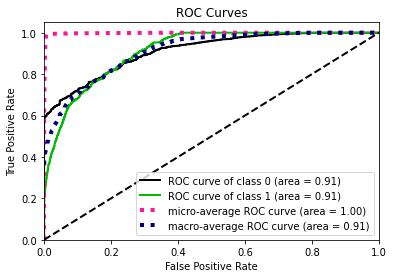

In [27]:
plot_roc(y_test, y_test_hat_proba)
plt.savefig('./output/roc.png')
mlflow.log_artifact('./output/roc.png')

In [28]:
mlflow.end_run()